Imagine you’re trying to guess how much a toy will cost in the future.

The toy price goes up and down randomly every day — like a roller coaster.

You want to decide:

“How much should I pay today for the right to buy the toy later?”

This right is called an option.

The Black–Scholes model is like a magic calculator that tells you the fair price of this option.
(I am using AI to learn the concepts)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import griddata, interp1d
from sklearn.utils import check_random_state
import yfinance as yf


plt.style.use('seaborn-v0_8-darkgrid')
# For Jupyter:
# %matplotlib inline
# to benchmark monte carlo pricing function we'll use Black-Scholes model
# Calculate theoretical price of European call or put option using Black-Scholes model
def black_scholes_price(S, K, r, sigma, T, option_type='call'):
  """
  1. S → Today’s toy/stock price

What the toy costs right now.

2. K → The agreed future buying price (strike)

The price you’re allowed to buy the toy for later.

3. T → How long until you can buy it

More time = more chances for big moves.

4. r → Risk-free interest rate

If you kept your money in the bank instead.

5. σ (sigma) → Volatility (how shaky the price is)

A “jumpy” toy price means more chances to rise a lot → makes options more valuable.
  """

  if T <= 0:
      if option_type == 'call':
          return max(S - K, 0.0)
      else:
          return max(K - S, 0.0)
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma*np.sqrt(T)
  if option_type == 'call':
      return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
  else:
      return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [5]:
ticker = '^GSPC'   # S&P500 index via Yahoo
start = '2015-01-01'
end = '2025-01-01'

print("Downloading price data for", ticker)
spx = yf.download(ticker, start=start, end=end, progress=False)
spx = spx[['Close']].rename(columns={'Close':'S'}) # Changed 'Adj Close' to 'Close'
spx['return'] = spx['S'].pct_change().fillna(0)
spx['logret'] = np.log(spx['S']).diff().fillna(0)
display(spx.head())

# Risk-free rate: simple constant (change to market data if preferred)
r = 0.05  # 3% annualized; adapt as needed

# Optional: load implied volatility surface CSV if you have it
import os
iv_path = 'cboe_spx_iv_surface.csv'
iv_surface = None
if os.path.exists(iv_path):
    print("Found implied vol surface:", iv_path)
    iv_surface = pd.read_csv(iv_path)
    display(iv_surface.head())
else:
    print("No implied vol CSV found. Continue using historical vol or flat vol.")

/tmp/ipython-input-3121880586.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spx = yf.download(ticker, start=start, end=end, progress=False)


Price,S,return,logret
Ticker,^GSPC,,
Date,,,
2015-01-02,2058.199951,0.000000,0.000000
2015-01-05,2020.579956,-0.018278,-0.018447
2015-01-06,2002.609985,-0.008893,-0.008933
2015-01-07,2025.900024,0.011630,0.011563
2015-01-08,2062.139893,0.017888,0.017730


No implied vol CSV found. Continue using historical vol or flat vol.


Hyptothetical Output of the below code
| path | t0  | t1    | t2    | ... | tn  |
| ---- | --- | ----- | ----- | --- | --- |
| 1    | 100 | 101.2 | 102.8 | ... | 120 |
| 2    | 100 | 99.7  | 101.1 | ... | 95  |
| 3    | 100 | 100.5 | 99.2  | ... | 110 |


The code simulates stock prices by discretizing the GBM stochastic differential equation using random normal shocks, then constructing a lognormal path with variance reduction tricks.

In [22]:
# Simuulate many possible price path for the underlying stock
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths, random_state=None,
                       antithetic=False, sobol=False):
    rng = check_random_state(random_state)
    dt = T / n_steps
    if False:
      pass

    else:
        z = rng.normal(size=(n_paths, n_steps))
    if antithetic:
        if n_paths % 2 != 0:
            raise ValueError("n_paths must be even for antithetic")
        half = n_paths // 2
        z_half = z[:half]
        z = np.vstack([z_half, -z_half])
    increments = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.zeros((n_paths, 1)), log_paths])  # include t=0
    S_paths = S0 * np.exp(log_paths)
    return S_paths  # shape (n_paths, n_steps+1)


In [9]:
def price_european_mc(S0, K, r, sigma, T, n_steps, n_paths,
                      option_type='call', random_state=None, antithetic=False, sobol=False):
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths,
                               random_state=random_state, antithetic=antithetic, sobol=sobol)
    ST = paths[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)
    disc_payoff = np.exp(-r*T) * payoffs
    price_mc = disc_payoff.mean()
    stderr = disc_payoff.std(ddof=1) / np.sqrt(len(disc_payoff))
    return price_mc, stderr


In [23]:
def price_asian_mc(S0, K, r, sigma, T, n_steps, n_paths,
                   option_type='call', random_state=None, antithetic=False, sobol=False,
                   include_t0=False):
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths,
                               random_state=random_state, antithetic=antithetic, sobol=sobol)
    if include_t0:
        avg = paths.mean(axis=1)       # include S0 at index 0
    else:
        avg = paths[:, 1:].mean(axis=1)  # exclude t0
    if option_type == 'call':
        payoffs = np.maximum(avg - K, 0.0)
    else:
        payoffs = np.maximum(K - avg, 0.0)
    price_mc = np.exp(-r*T) * payoffs.mean()
    stderr = (np.exp(-r*T) * payoffs).std(ddof=1) / np.sqrt(len(payoffs))
    return price_mc, stderr


In [24]:
def price_barrier_mc(S0, K, r, sigma, T, n_steps, n_paths, barrier,
                     option_type='call', knock_out=True,
                     barrier_type='up-and-out', random_state=None, antithetic=False, sobol=False):
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths,
                               random_state=random_state, antithetic=antithetic, sobol=sobol)
    if barrier_type == 'up-and-out':
        breached = (paths[:, 1:] >= barrier).any(axis=1)
    elif barrier_type == 'down-and-out':
        breached = (paths[:, 1:] <= barrier).any(axis=1)
    else:
        raise ValueError("Unsupported barrier_type")
    ST = paths[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)
    if knock_out:
        payoffs[breached] = 0.0
    price_mc = np.exp(-r*T) * payoffs.mean()
    stderr = (np.exp(-r*T) * payoffs).std(ddof=1) / np.sqrt(len(payoffs))
    return price_mc, stderr, int(breached.sum())


In [25]:
def price_european_mc_with_control(S0, K, r, sigma, T, n_steps, n_paths,
                                   option_type='call', random_state=None):
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths, random_state=random_state)
    ST = paths[:, -1]
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0.0)
    else:
        payoffs = np.maximum(K - ST, 0.0)
    disc_payoff = np.exp(-r*T) * payoffs

    # Control variate: discounted terminal stock (E[exp(-rT) ST] = S0)
    control = np.exp(-r*T) * ST
    control_mean = control.mean()
    target_mean = disc_payoff.mean()

    cov = np.cov(disc_payoff, control, ddof=1)[0,1]
    var_control = control.var(ddof=1)
    beta_opt = cov / var_control if var_control > 0 else 0.0

    adjusted = target_mean - beta_opt * (control_mean - S0)
    stderr = disc_payoff.std(ddof=1) / np.sqrt(len(disc_payoff))
    return adjusted, stderr, beta_opt


In [26]:
def delta_mc(S0, K, r, sigma, T, n_steps, n_paths, eps=1e-2, option_type='call', **mc_kwargs):
    p_up, _ = price_european_mc(S0*(1+eps), K, r, sigma, T, n_steps, n_paths, option_type=option_type, **mc_kwargs)
    p_down, _ = price_european_mc(S0*(1-eps), K, r, sigma, T, n_steps, n_paths, option_type=option_type, **mc_kwargs)
    return (p_up - p_down) / (2*S0*eps)

def vega_mc(S0, K, r, sigma, T, n_steps, n_paths, eps=1e-2, option_type='call', **mc_kwargs):
    p_up, _ = price_european_mc(S0, K, r, sigma*(1+eps), T, n_steps, n_paths, option_type=option_type, **mc_kwargs)
    p_down, _ = price_european_mc(S0, K, r, sigma*(1-eps), T, n_steps, n_paths, option_type=option_type, **mc_kwargs)
    return (p_up - p_down) / (2*sigma*eps)


In [27]:
S0 = float(spx['S'].iloc[-1])
K = S0 * 1.02
T = 30/365  # 30 days
sigma_hist = spx['logret'].std() * np.sqrt(252)
sigma = float(sigma_hist)
n_steps = 50
n_paths = 20000

print(f"S0={S0:.2f}, K={K:.2f}, T={T:.4f}, sigma(hist)={sigma:.4f}, r={r:.3f}")

price_mc, stderr = price_european_mc(S0, K, r, sigma, T, n_steps, n_paths, option_type='call', random_state=42)
bs_price = black_scholes_price(S0, K, r, sigma, T, option_type='call')
print("Plain MC price:", price_mc, "stderr:", stderr)
print("Black-Scholes price:", bs_price)

# Antithetic
if n_paths % 2 != 0:
    n_paths += 1
price_ant, stderr_ant = price_european_mc(S0, K, r, sigma, T, n_steps, n_paths, option_type='call', random_state=42, antithetic=True)
print("Antithetic MC price:", price_ant, "stderr:", stderr_ant)

# Control variate
price_cv, stderr_cv, beta = price_european_mc_with_control(S0, K, r, sigma, T, n_steps, n_paths, option_type='call', random_state=42)
print("Control variate adjusted price:", price_cv, "stderr:", stderr_cv, "beta:", beta)

# Asian and Barrier examples
price_asian, se_asian = price_asian_mc(S0, K, r, sigma, T, n_steps, n_paths, option_type='call', random_state=42)
print("Asian MC price:", price_asian, "stderr:", se_asian)

barrier = S0 * 1.10
price_bar, se_bar, breaches = price_barrier_mc(S0, K, r, sigma, T, n_steps, n_paths, barrier,
                                              option_type='call', knock_out=True, barrier_type='up-and-out',
                                              random_state=42, antithetic=False)
print("Barrier MC price:", price_bar, "stderr:", se_bar, "breaches:", breaches)

# Greeks
delta_est = delta_mc(S0, K, r, sigma, T, n_steps, n_paths//20, option_type='call', random_state=123)
vega_est = vega_mc(S0, K, r, sigma, T, n_steps, n_paths//20, option_type='call', random_state=123)
print("Delta (MC FD):", delta_est, "Vega (MC FD):", vega_est)


/tmp/ipython-input-2639740304.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(spx['S'].iloc[-1])


S0=5881.63, K=5999.26, T=0.0822, sigma(hist)=0.1789, r=0.030
Plain MC price: 75.63920908682394 stderr: 1.0325962859566322
Black-Scholes price: 76.80191315555703
Antithetic MC price: 77.45726976417028 stderr: 1.0488011032011075
Control variate adjusted price: 76.94058297817881 stderr: 1.0325962859566322 beta: 0.3843012323391357
Asian MC price: 28.842314514982448 stderr: 0.48157620074547547
Barrier MC price: 48.117258122601804 stderr: 0.6831053104597181 breaches: 1091
Delta (MC FD): 0.3835646230158653 Vega (MC FD): 691.348236966809


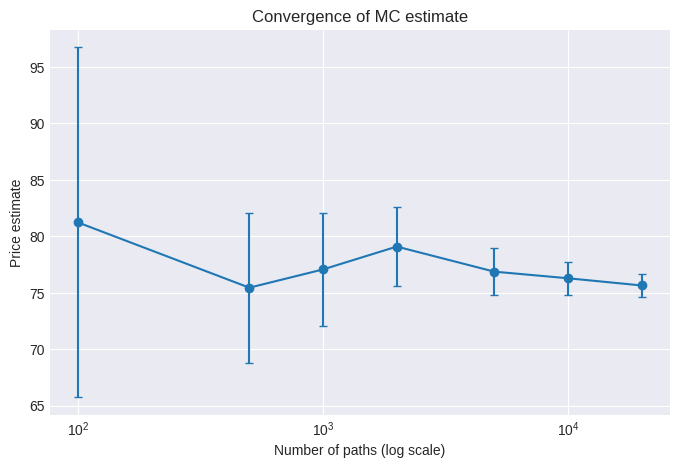

In [28]:

def convergence_plot(estimator_func, S0, K, r, sigma, T, n_steps, N_list, option_type='call', **kwargs):
    estimates = []
    errs = []
    for N in N_list:
        price, stderr = estimator_func(S0, K, r, sigma, T, n_steps, N, option_type=option_type, **kwargs)
        estimates.append(price)
        errs.append(stderr)
    plt.figure(figsize=(8,5))
    plt.errorbar(N_list, estimates, yerr=errs, fmt='o-', capsize=3)
    plt.xscale('log')
    plt.xlabel('Number of paths (log scale)')
    plt.ylabel('Price estimate')
    plt.title('Convergence of MC estimate')
    plt.show()

N_list = [100, 500, 1000, 2000, 5000, 10000, 20000]
convergence_plot(price_european_mc, S0, K, r, sigma, T, n_steps, N_list, option_type='call', random_state=42)
